In [1]:
# uncomment on first runs
!git clone https://github.com/trung8134/NCKH_xAI.git

Cloning into 'NCKH-FR-2023'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 102 (delta 19), reused 29 (delta 12), pack-reused 66
Receiving objects: 100% (102/102), 41.42 KiB | 5.92 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
pip install gdown

In [ ]:
# Nếu dùng colab thì hãy chạy line này
import os
import gdown

# Đi tới thư mục chính
os.chdir('NCKH_xAI')

# Tạo thư mục 'datasets'
os.makedirs('Datasets', exist_ok=True)

# Lưu lại thư mục làm việc hiện tại
current_directory = os.getcwd()

# Di chuyển đến thư mục 'datasets'
os.chdir('Datasets')

# URL chia sẻ của tệp bạn muốn tải xuống từ Google Drives
file_url = 'https://drive.google.com/uc?id=198z59C3HVKv1scCwkj5bdzIqPqjE2OsO'

# Sử dụng gdown.download để tải xuống tệp
gdown.download(file_url, output='data.zip')

# Giải nén tệp nếu cần thiết
os.system('unzip data.zip')

# Quay lại thư mục trước 'datasets'
os.chdir(current_directory)

# Contrastive Classification



In [ ]:
!pip install tensorflow-addons
!pip install git+https://github.com/qubvel/classification_models.git

In [1]:
from tensorflow import keras
from models import create_encoder_ResNet18, create_encoder_ResNet50
from dataset import tf_dataset
from classifier import create_classifier

# Prepare the data

# Using image data augmentation

In [2]:
img_size = 224
num_classes = 11
batch_size = 32
input_shape = (img_size, img_size, 3)

In [ ]:
train_ds, val_ds, test_ds = tf_dataset(img_size=img_size, batch_size=batch_size)

In [4]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


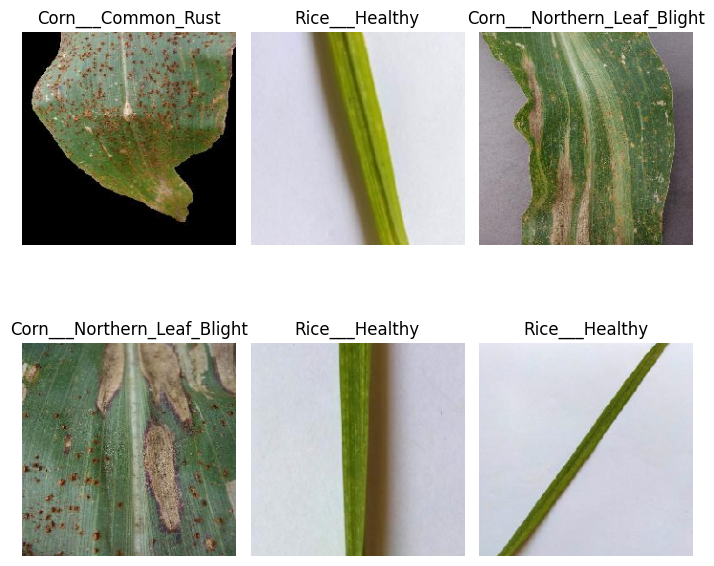

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plotImages(images_arr, labels_onehot, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(7,7))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_onehot, axes):
        ax.imshow(img)
        class_index = np.argmax(label)
        class_name = class_names[class_index]
        
        ax.set_title(class_name)  
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Show the first batch
imgs, labels = train_ds[5]
rows = 2
cols = 3
sum = rows * cols
plotImages(imgs[:sum], labels[:sum], rows, cols)

# Build the model


Định nghĩa các siêu tham số, gọi encoder

In [26]:
# hyperparameter
learning_rate = 1e-4
hidden_units = 128
num_epochs = 50
dropout_rate = 0.5
activation = "relu"

# 1. Create the encoder with transfer learning

In [27]:
# Định nghĩa lớp encoder 
encoder = create_encoder_ResNet18(img_size=img_size, num_classes=num_classes)

encoder.summary()

Model: "Encoder-ResNet18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 7, 7, 512)         11186889  
                                                                 
Total params: 11186889 (42.67 MB)
Trainable params: 11178947 (42.64 MB)
Non-trainable params: 7942 (31.02 KB)
_________________________________________________________________


In [28]:
# Định nghĩa lớp phân loại 
encoder_classifier = create_classifier(encoder, input_shape, hidden_units, activation, dropout_rate, num_classes, learning_rate, trainable=False)

encoder_classifier.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Encoder-ResNet18 (Function  (None, 7, 7, 512)         11186889  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                        

In [29]:
# callbacks
es = keras.callbacks.EarlyStopping('val_accuracy', patience=6, verbose=1)

In [ ]:
# Train lớp phân loại
history = encoder_classifier.fit(x = train_ds,
        validation_data = test_ds,
        epochs=num_epochs,
        callbacks=[es])

In [58]:
# Đánh giá
loss, accuracy = encoder_classifier.evaluate(test_ds)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

201/201 [==============================] - 14s 70ms/step - loss: 1.1758 - sparse_categorical_accuracy: 0.7298
Test accuracy: 72.98%
